In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import itertools
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,RobustScaler,Normalizer,MaxAbsScaler
from sklearn.model_selection import train_test_split
from airbnbCABATransformer import AirbnbCABATransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_log_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Cargamos el dataset limpio 
data = pd.read_csv('data/listings.csv')
data1 = pd.read_csv('data/listings_1.csv')
data2 = pd.read_csv('data/listings_2.csv')
data3 = pd.read_csv('data/listings_3.csv')
data = pd.concat([data, data1,data2,data3])
#data = data.drop_duplicates(subset=data.columns.difference(['price']))
data = data.drop_duplicates()
data = data.reset_index()


In [3]:
dataclean = AirbnbCABATransformer().transform(data)
dataclean.head()

/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,host_identity_verified,accommodates,bathrooms,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,air_conditioning,...,Villa Santa Rita,Villa Soldati,Villa Urquiza,Apartment,House,Entire home/apt,Private room,Shared room,bathroomtype_private,bathroomtype_shared
0,1.0,2,1,1,9823,3,1125,30,4.77,1,...,0,0,0,1,0,1,0,0,1,0
1,1.0,2,1,1,5687,2,730,24,4.63,1,...,0,0,0,1,0,1,0,0,1,0
2,1.0,2,1,1,3728,7,1125,98,4.77,1,...,0,0,0,1,0,1,0,0,1,0
3,1.0,4,2,1,6514,14,1125,10,4.67,1,...,0,0,0,1,0,1,0,0,1,0
4,1.0,2,1,1,3584,5,730,29,4.79,1,...,0,0,0,1,0,1,0,0,1,0


In [4]:
dataclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64326 entries, 0 to 67144
Data columns (total 73 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_identity_verified  64326 non-null  float64
 1   accommodates            64326 non-null  int64  
 2   bathrooms               64326 non-null  int64  
 3   bedrooms                64326 non-null  int64  
 4   price                   64326 non-null  int64  
 5   minimum_nights          64326 non-null  int64  
 6   maximum_nights          64326 non-null  int64  
 7   number_of_reviews       64326 non-null  int64  
 8   review_scores_rating    64326 non-null  float64
 9   air_conditioning        64326 non-null  int64  
 10  pool                    64326 non-null  int64  
 11  parking                 64326 non-null  int64  
 12  tv                      64326 non-null  int64  
 13  internet                64326 non-null  int64  
 14  gym                     64326 non-null

In [5]:
#Genero mi variable X
X=dataclean.drop(['price'],axis=1)

#Genero la variable y
y = dataclean['price']

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10,shuffle=True)

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=41)

In [6]:

pasos = [('preprocessor', MinMaxScaler()), 
         ('regresor', LinearRegression())]

pipe=Pipeline(pasos)



In [7]:
def make_param_grids(steps, param_grids):

    final_params=[]

    for estimator_names in itertools.product(*steps.values()):
        current_grid = {}

        for step_name, estimator_name in zip(steps.keys(), estimator_names):            
            for param, value in param_grids.get(estimator_name).items():
                if param == 'object':
                    # Set actual estimator in pipeline
                    current_grid[step_name]=[value]
                else:
                    # Set parameters corresponding to above estimator
                    current_grid[step_name+'__'+param]=value
        #Append this dictionary to final params            
        final_params.append(current_grid)

    return final_params

pipeline_steps = {'preprocessor':['ssc', 'mms','none','abs','norm','rss'],
                  'regresor':['lr', 'rf']}

# fill parameters to be searched in this dict
all_param_grids = {'lr':{'object':LinearRegression()
                         }, 

                   'rf':{'object':RandomForestRegressor(),                                                  
                        },

                   'ssc':{'object':StandardScaler()
                         },

                   'mms':{'object':MinMaxScaler()
                         },                   
                   'none':{'object':None
                         },                   
                    'abs':{'object': MaxAbsScaler()                        
                          },
                   'norm':{'object': Normalizer()                        
                          },
                   'rss':{'object': RobustScaler()                        
                          }
                  }  

# Call the method on the above declared variables
param_grids_list = make_param_grids(pipeline_steps, all_param_grids)

In [8]:
param_grids_list

[{'preprocessor': [StandardScaler()], 'regresor': [LinearRegression()]},
 {'preprocessor': [StandardScaler()], 'regresor': [RandomForestRegressor()]},
 {'preprocessor': [MinMaxScaler()], 'regresor': [LinearRegression()]},
 {'preprocessor': [MinMaxScaler()], 'regresor': [RandomForestRegressor()]},
 {'preprocessor': [None], 'regresor': [LinearRegression()]},
 {'preprocessor': [None], 'regresor': [RandomForestRegressor()]},
 {'preprocessor': [MaxAbsScaler()], 'regresor': [LinearRegression()]},
 {'preprocessor': [MaxAbsScaler()], 'regresor': [RandomForestRegressor()]},
 {'preprocessor': [Normalizer()], 'regresor': [LinearRegression()]},
 {'preprocessor': [Normalizer()], 'regresor': [RandomForestRegressor()]},
 {'preprocessor': [RobustScaler()], 'regresor': [LinearRegression()]},
 {'preprocessor': [RobustScaler()], 'regresor': [RandomForestRegressor()]}]

In [9]:
%%time

grid=GridSearchCV(pipe, param_grid = param_grids_list, cv=folds,verbose=1, n_jobs=-1)
    
# grid.fit(X_train,y_train)

CPU times: user 71 µs, sys: 0 ns, total: 71 µs
Wall time: 73.9 µs


In [10]:
# print(grid.best_estimator_)

In [11]:
# grid.best_estimator_.score(X_test,y_test)

### scores

In [12]:

def getscores(model,X_test,y_test,X_train,y_train):
    y_pred_test = model.predict(X_test)
    
    mse_test = np.round(mean_squared_error(y_test, y_pred_test),3)
    rmse_test = np.round(np.sqrt(mse_test),3)
    mae_test = np.round(mean_absolute_error(y_test, y_pred_test),3)
    r2_test =  r2_score(y_test, y_pred_test)

    print('---- TEST ---')
    print('MAE   :', mae_test)
    print('MSE   :', mse_test)
    print('RMSE  :', rmse_test)
    print('R^2   :', r2_test)

    y_pred_train = model.predict(X_train)

    mse_train = np.round(mean_squared_error(y_train, y_pred_train),3)
    rmse_train = np.round(np.sqrt(mse_train),3)
    mae_train = np.round(mean_absolute_error(y_train, y_pred_train),3)
    r2_train =  r2_score(y_train, y_pred_train)

    print('---- TRAIN ---')
    print('MAE   :', mae_train)
    print('MSE   :', mse_train)
    print('RMSE  :', rmse_train)
    print('R^2 = :', r2_train)
    
    #Gráfico de los valores vs los predecidos
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

    axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
    axes[0].plot([i for i in range(len(y_test))],y_pred_test, 'bo', label="Predicted LR values")
    axes[0].legend()

    axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
    axes[1].plot([i for i in range(len(y_train))],y_pred_train, 'bo', label="Predicted LR values")
    axes[1].legend()

    fig.text(0.5, 0.09, 'Item', ha='center')
    fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
    plt.show()    
     


In [13]:
# getscores(grid.best_estimator_,X_test,y_test,X_train,y_train)

### Scaler

### CatBoostRegressor 

In [14]:
%%time

params_cat = {  

}

grid_cat=GridSearchCV(CatBoostRegressor(), param_grid = params_cat, cv=folds,verbose=1, n_jobs=-1)
  
grid_cat.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Learning rate set to 0.07213
0:	learn: 4396.7797584	total: 50.5ms	remaining: 50.4s
1:	learn: 4302.9568433	total: 53.9ms	remaining: 26.9s
2:	learn: 4220.8760559	total: 61ms	remaining: 20.3s
3:	learn: 4150.5391476	total: 81.9ms	remaining: 20.4s
4:	learn: 4083.9635609	total: 102ms	remaining: 20.3s
5:	learn: 4023.7909302	total: 114ms	remaining: 19s
6:	learn: 3972.5004296	total: 118ms	remaining: 16.8s
7:	learn: 3927.6250752	total: 125ms	remaining: 15.5s
8:	learn: 3883.9362837	total: 134ms	remaining: 14.8s
9:	learn: 3847.3356677	total: 139ms	remaining: 13.7s
10:	learn: 3814.6529555	total: 143ms	remaining: 12.8s
11:	learn: 3784.4106695	total: 160ms	remaining: 13.2s
12:	learn: 3756.9650892	total: 166ms	remaining: 12.6s
13:	learn: 3730.6151224	total: 169ms	remaining: 11.9s
14:	learn: 3706.7377024	total: 175ms	remaining: 11.5s
15:	learn: 3683.9910998	total: 214ms	remaining: 13.2s
16:	learn: 3663.4196399	total: 218ms	remaining: 12.6s
17:	learn: 3646.2207568	total: 221ms	remaining: 12.1s
18:	learn

Learning rate set to 0.07213
0:	learn: 4377.5661582	total: 62.1ms	remaining: 1m 2s
1:	learn: 4286.5396394	total: 74.2ms	remaining: 37s
2:	learn: 4206.3131940	total: 104ms	remaining: 34.7s
3:	learn: 4132.5916511	total: 115ms	remaining: 28.6s
4:	learn: 4066.3084960	total: 131ms	remaining: 26s
5:	learn: 4008.3302273	total: 134ms	remaining: 22.2s
6:	learn: 3958.5547133	total: 138ms	remaining: 19.5s
7:	learn: 3913.0174758	total: 142ms	remaining: 17.7s
8:	learn: 3870.2758071	total: 163ms	remaining: 18s
9:	learn: 3832.8113577	total: 207ms	remaining: 20.5s
10:	learn: 3799.3554847	total: 223ms	remaining: 20s
11:	learn: 3768.1522710	total: 255ms	remaining: 21s
12:	learn: 3741.0540503	total: 262ms	remaining: 19.9s
13:	learn: 3715.4733326	total: 346ms	remaining: 24.4s
14:	learn: 3694.4960656	total: 352ms	remaining: 23.1s
15:	learn: 3674.3327310	total: 370ms	remaining: 22.8s
16:	learn: 3655.6457225	total: 375ms	remaining: 21.7s
17:	learn: 3637.9871109	total: 380ms	remaining: 20.7s
18:	learn: 3621.4

150:	learn: 3308.0395027	total: 2.55s	remaining: 14.4s
151:	learn: 3307.1831469	total: 2.58s	remaining: 14.4s
152:	learn: 3306.3927047	total: 2.58s	remaining: 14.3s
153:	learn: 3305.7748833	total: 2.59s	remaining: 14.2s
154:	learn: 3304.8908835	total: 2.59s	remaining: 14.1s
155:	learn: 3302.9990492	total: 2.6s	remaining: 14.1s
156:	learn: 3301.7278399	total: 2.6s	remaining: 14s
157:	learn: 3301.3060282	total: 2.6s	remaining: 13.9s
158:	learn: 3300.0158980	total: 2.61s	remaining: 13.8s
159:	learn: 3299.5795765	total: 2.63s	remaining: 13.8s
160:	learn: 3298.9101801	total: 2.64s	remaining: 13.8s
161:	learn: 3297.7651141	total: 2.65s	remaining: 13.7s
162:	learn: 3296.9211756	total: 2.66s	remaining: 13.7s
163:	learn: 3296.4684932	total: 2.66s	remaining: 13.6s
164:	learn: 3295.7751130	total: 2.67s	remaining: 13.5s
165:	learn: 3294.8959310	total: 2.76s	remaining: 13.9s
166:	learn: 3293.8134251	total: 2.78s	remaining: 13.8s
167:	learn: 3293.0312927	total: 2.79s	remaining: 13.8s
168:	learn: 329

151:	learn: 3301.9028505	total: 2.74s	remaining: 15.3s
152:	learn: 3301.0846189	total: 2.75s	remaining: 15.2s
153:	learn: 3300.2780093	total: 2.75s	remaining: 15.1s
154:	learn: 3299.7292190	total: 2.76s	remaining: 15.1s
155:	learn: 3298.9247486	total: 2.77s	remaining: 15s
156:	learn: 3297.7260890	total: 2.79s	remaining: 15s
157:	learn: 3296.1714572	total: 2.79s	remaining: 14.9s
158:	learn: 3295.5222097	total: 2.8s	remaining: 14.8s
159:	learn: 3294.7261242	total: 2.82s	remaining: 14.8s
160:	learn: 3293.9775362	total: 2.83s	remaining: 14.7s
161:	learn: 3293.2486206	total: 2.83s	remaining: 14.7s
162:	learn: 3292.0907464	total: 2.84s	remaining: 14.6s
163:	learn: 3290.4580864	total: 2.85s	remaining: 14.5s
164:	learn: 3289.6168982	total: 2.86s	remaining: 14.5s
165:	learn: 3288.2406058	total: 2.87s	remaining: 14.4s
166:	learn: 3287.4588637	total: 2.87s	remaining: 14.3s
167:	learn: 3286.7347042	total: 2.89s	remaining: 14.3s
168:	learn: 3286.0021079	total: 2.95s	remaining: 14.5s
169:	learn: 328

151:	learn: 3314.4814819	total: 3s	remaining: 16.7s
152:	learn: 3313.5729884	total: 3.02s	remaining: 16.7s
153:	learn: 3313.1535089	total: 3.03s	remaining: 16.6s
154:	learn: 3312.4140630	total: 3.05s	remaining: 16.6s
155:	learn: 3311.6267475	total: 3.07s	remaining: 16.6s
156:	learn: 3310.8927846	total: 3.07s	remaining: 16.5s
157:	learn: 3309.6216819	total: 3.08s	remaining: 16.4s
158:	learn: 3309.1730974	total: 3.09s	remaining: 16.4s
159:	learn: 3308.6883074	total: 3.09s	remaining: 16.2s
160:	learn: 3308.2645054	total: 3.14s	remaining: 16.3s
161:	learn: 3307.6944344	total: 3.16s	remaining: 16.4s
162:	learn: 3306.9926395	total: 3.22s	remaining: 16.6s
163:	learn: 3306.0190003	total: 3.24s	remaining: 16.5s
164:	learn: 3305.2384271	total: 3.27s	remaining: 16.5s
165:	learn: 3304.1691439	total: 3.29s	remaining: 16.5s
166:	learn: 3303.6799738	total: 3.29s	remaining: 16.4s
167:	learn: 3303.0775045	total: 3.3s	remaining: 16.4s
168:	learn: 3302.5230414	total: 3.31s	remaining: 16.3s
169:	learn: 33

300:	learn: 3202.9679239	total: 5.01s	remaining: 11.6s
301:	learn: 3202.6217584	total: 5.01s	remaining: 11.6s
302:	learn: 3202.1668708	total: 5.02s	remaining: 11.5s
303:	learn: 3201.9309335	total: 5.04s	remaining: 11.5s
304:	learn: 3201.4398137	total: 5.09s	remaining: 11.6s
305:	learn: 3201.2174294	total: 5.12s	remaining: 11.6s
306:	learn: 3201.0136836	total: 5.13s	remaining: 11.6s
307:	learn: 3200.6180473	total: 5.13s	remaining: 11.5s
308:	learn: 3199.8496887	total: 5.14s	remaining: 11.5s
309:	learn: 3199.6270956	total: 5.14s	remaining: 11.4s
310:	learn: 3199.3959532	total: 5.15s	remaining: 11.4s
311:	learn: 3199.0478029	total: 5.15s	remaining: 11.4s
312:	learn: 3198.6903186	total: 5.16s	remaining: 11.3s
313:	learn: 3198.1647726	total: 5.16s	remaining: 11.3s
314:	learn: 3197.6663910	total: 5.16s	remaining: 11.2s
315:	learn: 3197.0919646	total: 5.17s	remaining: 11.2s
316:	learn: 3196.6230956	total: 5.17s	remaining: 11.1s
317:	learn: 3196.0721800	total: 5.18s	remaining: 11.1s
318:	learn

300:	learn: 3222.9171640	total: 5.26s	remaining: 12.2s
301:	learn: 3222.4828437	total: 5.27s	remaining: 12.2s
302:	learn: 3222.0229366	total: 5.28s	remaining: 12.1s
303:	learn: 3221.7503429	total: 5.3s	remaining: 12.1s
304:	learn: 3221.4131464	total: 5.33s	remaining: 12.1s
305:	learn: 3221.2010061	total: 5.33s	remaining: 12.1s
306:	learn: 3220.7616387	total: 5.37s	remaining: 12.1s
307:	learn: 3220.5017857	total: 5.41s	remaining: 12.2s
308:	learn: 3219.8935725	total: 5.43s	remaining: 12.2s
309:	learn: 3219.4647618	total: 5.44s	remaining: 12.1s
310:	learn: 3218.9497461	total: 5.46s	remaining: 12.1s
311:	learn: 3218.5698704	total: 5.47s	remaining: 12.1s
312:	learn: 3217.9689444	total: 5.48s	remaining: 12s
313:	learn: 3217.6955084	total: 5.51s	remaining: 12s
314:	learn: 3217.2505733	total: 5.54s	remaining: 12.1s
315:	learn: 3216.7671062	total: 5.55s	remaining: 12s
316:	learn: 3216.4539484	total: 5.55s	remaining: 12s
317:	learn: 3215.8548947	total: 5.6s	remaining: 12s
318:	learn: 3215.36881

449:	learn: 3155.2205126	total: 7.66s	remaining: 9.36s
450:	learn: 3154.9598923	total: 7.71s	remaining: 9.38s
451:	learn: 3154.6340251	total: 7.71s	remaining: 9.35s
452:	learn: 3154.1270809	total: 7.74s	remaining: 9.34s
453:	learn: 3153.9202648	total: 7.74s	remaining: 9.31s
454:	learn: 3153.4176924	total: 7.75s	remaining: 9.28s
455:	learn: 3152.4826311	total: 7.75s	remaining: 9.25s
456:	learn: 3152.3427026	total: 7.77s	remaining: 9.24s
457:	learn: 3151.9314799	total: 7.81s	remaining: 9.24s
458:	learn: 3151.7247911	total: 7.82s	remaining: 9.21s
459:	learn: 3151.3241533	total: 7.82s	remaining: 9.18s
460:	learn: 3151.1493267	total: 7.85s	remaining: 9.18s
461:	learn: 3150.7106645	total: 7.86s	remaining: 9.15s
462:	learn: 3150.0929264	total: 7.87s	remaining: 9.12s
463:	learn: 3149.6416803	total: 7.88s	remaining: 9.1s
464:	learn: 3149.0787402	total: 7.9s	remaining: 9.09s
465:	learn: 3148.9467117	total: 7.92s	remaining: 9.07s
466:	learn: 3148.8320032	total: 7.92s	remaining: 9.04s
467:	learn: 

598:	learn: 3083.9932757	total: 9.25s	remaining: 6.2s
599:	learn: 3083.5659343	total: 9.26s	remaining: 6.17s
600:	learn: 3083.4859924	total: 9.27s	remaining: 6.15s
601:	learn: 3082.9518847	total: 9.27s	remaining: 6.13s
602:	learn: 3082.8210320	total: 9.27s	remaining: 6.11s
603:	learn: 3082.4291139	total: 9.3s	remaining: 6.1s
604:	learn: 3082.1151440	total: 9.32s	remaining: 6.09s
605:	learn: 3081.6844368	total: 9.34s	remaining: 6.07s
606:	learn: 3081.4371452	total: 9.37s	remaining: 6.06s
607:	learn: 3081.1189437	total: 9.4s	remaining: 6.06s
608:	learn: 3080.9798428	total: 9.42s	remaining: 6.05s
609:	learn: 3080.5937031	total: 9.42s	remaining: 6.03s
610:	learn: 3080.1198418	total: 9.43s	remaining: 6s
611:	learn: 3079.8724306	total: 9.45s	remaining: 5.99s
612:	learn: 3079.5636989	total: 9.46s	remaining: 5.97s
613:	learn: 3079.0677353	total: 9.46s	remaining: 5.95s
614:	learn: 3078.9317379	total: 9.46s	remaining: 5.92s
615:	learn: 3078.5879472	total: 9.47s	remaining: 5.91s
616:	learn: 3078.

598:	learn: 3080.0603256	total: 9.26s	remaining: 6.2s
599:	learn: 3079.2335249	total: 9.27s	remaining: 6.18s
600:	learn: 3078.9315755	total: 9.27s	remaining: 6.16s
601:	learn: 3078.6464560	total: 9.28s	remaining: 6.13s
602:	learn: 3077.9258844	total: 9.28s	remaining: 6.11s
603:	learn: 3077.6123026	total: 9.29s	remaining: 6.09s
604:	learn: 3076.9590399	total: 9.33s	remaining: 6.09s
605:	learn: 3076.5206277	total: 9.37s	remaining: 6.09s
606:	learn: 3076.2550220	total: 9.38s	remaining: 6.07s
607:	learn: 3075.9352109	total: 9.42s	remaining: 6.07s
608:	learn: 3075.6318670	total: 9.46s	remaining: 6.07s
609:	learn: 3075.3009179	total: 9.47s	remaining: 6.05s
610:	learn: 3074.7018002	total: 9.47s	remaining: 6.03s
611:	learn: 3074.4972465	total: 9.47s	remaining: 6.01s
612:	learn: 3074.1629820	total: 9.48s	remaining: 5.98s
613:	learn: 3073.8511240	total: 9.59s	remaining: 6.03s
614:	learn: 3073.6488564	total: 9.61s	remaining: 6.01s
615:	learn: 3073.4223519	total: 9.61s	remaining: 5.99s
616:	learn:

598:	learn: 3102.3982847	total: 10s	remaining: 6.71s
599:	learn: 3101.9117522	total: 10s	remaining: 6.69s
600:	learn: 3101.6417967	total: 10s	remaining: 6.67s
601:	learn: 3101.3298302	total: 10.1s	remaining: 6.66s
602:	learn: 3100.9098720	total: 10.1s	remaining: 6.65s
603:	learn: 3100.5525069	total: 10.1s	remaining: 6.63s
604:	learn: 3100.2621736	total: 10.1s	remaining: 6.61s
605:	learn: 3099.4000324	total: 10.1s	remaining: 6.59s
606:	learn: 3098.5013651	total: 10.1s	remaining: 6.56s
607:	learn: 3098.3970415	total: 10.1s	remaining: 6.54s
608:	learn: 3098.0133399	total: 10.2s	remaining: 6.52s
609:	learn: 3097.8084204	total: 10.2s	remaining: 6.5s
610:	learn: 3097.1508545	total: 10.2s	remaining: 6.47s
611:	learn: 3096.8630179	total: 10.2s	remaining: 6.45s
612:	learn: 3096.6132184	total: 10.2s	remaining: 6.42s
613:	learn: 3096.0643172	total: 10.2s	remaining: 6.4s
614:	learn: 3095.8177391	total: 10.2s	remaining: 6.39s
615:	learn: 3095.3871049	total: 10.2s	remaining: 6.37s
616:	learn: 3095.2

746:	learn: 3051.0937327	total: 11.9s	remaining: 4.04s
747:	learn: 3050.7067046	total: 12s	remaining: 4.03s
748:	learn: 3050.4793375	total: 12s	remaining: 4.01s
749:	learn: 3050.3181217	total: 12s	remaining: 4s
750:	learn: 3049.9249124	total: 12s	remaining: 3.98s
751:	learn: 3049.6608724	total: 12s	remaining: 3.96s
752:	learn: 3049.2051609	total: 12.1s	remaining: 3.96s
753:	learn: 3048.9803579	total: 12.1s	remaining: 3.94s
754:	learn: 3048.6647864	total: 12.1s	remaining: 3.92s
755:	learn: 3048.4611883	total: 12.1s	remaining: 3.9s
756:	learn: 3048.2172756	total: 12.1s	remaining: 3.88s
757:	learn: 3048.0689696	total: 12.1s	remaining: 3.87s
758:	learn: 3047.4936385	total: 12.1s	remaining: 3.85s
759:	learn: 3047.3731939	total: 12.1s	remaining: 3.83s
760:	learn: 3047.1454165	total: 12.1s	remaining: 3.81s
761:	learn: 3046.6956488	total: 12.1s	remaining: 3.79s
762:	learn: 3046.3177732	total: 12.1s	remaining: 3.77s
763:	learn: 3046.0881695	total: 12.1s	remaining: 3.75s
764:	learn: 3045.5266240

747:	learn: 3052.4515205	total: 12s	remaining: 4.05s
748:	learn: 3052.2951521	total: 12s	remaining: 4.03s
749:	learn: 3052.0397128	total: 12s	remaining: 4.01s
750:	learn: 3051.6769892	total: 12.1s	remaining: 4s
751:	learn: 3051.5423386	total: 12.1s	remaining: 3.98s
752:	learn: 3051.3674461	total: 12.1s	remaining: 3.96s
753:	learn: 3050.7925709	total: 12.1s	remaining: 3.95s
754:	learn: 3050.4222131	total: 12.1s	remaining: 3.93s
755:	learn: 3050.2082237	total: 12.1s	remaining: 3.92s
756:	learn: 3050.0427354	total: 12.1s	remaining: 3.9s
757:	learn: 3049.5027366	total: 12.2s	remaining: 3.88s
758:	learn: 3049.1446313	total: 12.2s	remaining: 3.86s
759:	learn: 3048.8009256	total: 12.2s	remaining: 3.84s
760:	learn: 3048.5627974	total: 12.2s	remaining: 3.82s
761:	learn: 3048.4315080	total: 12.2s	remaining: 3.8s
762:	learn: 3048.1506056	total: 12.2s	remaining: 3.78s
763:	learn: 3047.7123866	total: 12.2s	remaining: 3.77s
764:	learn: 3047.1644444	total: 12.2s	remaining: 3.75s
765:	learn: 3046.7198

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished


Learning rate set to 0.074719
0:	learn: 4385.2764477	total: 50.5ms	remaining: 50.4s
1:	learn: 4289.6100020	total: 54.3ms	remaining: 27.1s
2:	learn: 4206.5744731	total: 57.7ms	remaining: 19.2s
3:	learn: 4132.3634749	total: 60.6ms	remaining: 15.1s
4:	learn: 4064.8488171	total: 64.1ms	remaining: 12.8s
5:	learn: 4006.3125159	total: 66.9ms	remaining: 11.1s
6:	learn: 3956.1823451	total: 69.6ms	remaining: 9.87s
7:	learn: 3910.8530684	total: 72.7ms	remaining: 9.01s
8:	learn: 3867.7046146	total: 76.3ms	remaining: 8.4s
9:	learn: 3832.4443023	total: 79.4ms	remaining: 7.87s
10:	learn: 3799.1729391	total: 82.4ms	remaining: 7.41s
11:	learn: 3769.1241323	total: 85.4ms	remaining: 7.03s
12:	learn: 3741.8324591	total: 90ms	remaining: 6.83s
13:	learn: 3715.7741498	total: 93.7ms	remaining: 6.6s
14:	learn: 3695.8299659	total: 97.3ms	remaining: 6.39s
15:	learn: 3674.1101528	total: 101ms	remaining: 6.24s
16:	learn: 3654.8681547	total: 104ms	remaining: 6.04s
17:	learn: 3638.3976026	total: 107ms	remaining: 5.8

203:	learn: 3272.1275716	total: 649ms	remaining: 2.53s
204:	learn: 3271.7662783	total: 652ms	remaining: 2.53s
205:	learn: 3270.8959858	total: 655ms	remaining: 2.52s
206:	learn: 3269.9784780	total: 659ms	remaining: 2.52s
207:	learn: 3269.5148705	total: 661ms	remaining: 2.52s
208:	learn: 3268.6987662	total: 664ms	remaining: 2.51s
209:	learn: 3268.0187801	total: 670ms	remaining: 2.52s
210:	learn: 3267.5778034	total: 673ms	remaining: 2.52s
211:	learn: 3267.1143733	total: 676ms	remaining: 2.51s
212:	learn: 3266.5234617	total: 678ms	remaining: 2.51s
213:	learn: 3265.6804085	total: 681ms	remaining: 2.5s
214:	learn: 3264.7278710	total: 684ms	remaining: 2.5s
215:	learn: 3264.0675034	total: 686ms	remaining: 2.49s
216:	learn: 3263.6742559	total: 689ms	remaining: 2.48s
217:	learn: 3263.1439912	total: 691ms	remaining: 2.48s
218:	learn: 3262.8313693	total: 693ms	remaining: 2.47s
219:	learn: 3261.9798255	total: 696ms	remaining: 2.47s
220:	learn: 3261.3018326	total: 698ms	remaining: 2.46s
221:	learn: 

379:	learn: 3180.9511479	total: 1.13s	remaining: 1.84s
380:	learn: 3180.4932988	total: 1.13s	remaining: 1.84s
381:	learn: 3180.2729202	total: 1.14s	remaining: 1.84s
382:	learn: 3179.7784811	total: 1.14s	remaining: 1.84s
383:	learn: 3179.3029300	total: 1.14s	remaining: 1.83s
384:	learn: 3179.1631489	total: 1.15s	remaining: 1.83s
385:	learn: 3178.7165807	total: 1.15s	remaining: 1.83s
386:	learn: 3178.1807064	total: 1.15s	remaining: 1.82s
387:	learn: 3178.0057289	total: 1.15s	remaining: 1.82s
388:	learn: 3177.7942200	total: 1.16s	remaining: 1.82s
389:	learn: 3177.2627367	total: 1.16s	remaining: 1.81s
390:	learn: 3176.9585946	total: 1.16s	remaining: 1.81s
391:	learn: 3176.6992865	total: 1.17s	remaining: 1.81s
392:	learn: 3176.2547628	total: 1.17s	remaining: 1.8s
393:	learn: 3176.0785452	total: 1.17s	remaining: 1.8s
394:	learn: 3175.8250346	total: 1.17s	remaining: 1.79s
395:	learn: 3175.6504942	total: 1.18s	remaining: 1.79s
396:	learn: 3175.4241264	total: 1.18s	remaining: 1.79s
397:	learn: 

556:	learn: 3114.4186519	total: 1.62s	remaining: 1.28s
557:	learn: 3114.1660911	total: 1.62s	remaining: 1.28s
558:	learn: 3113.9408053	total: 1.62s	remaining: 1.28s
559:	learn: 3113.5763800	total: 1.63s	remaining: 1.28s
560:	learn: 3113.3329974	total: 1.63s	remaining: 1.27s
561:	learn: 3112.9477979	total: 1.63s	remaining: 1.27s
562:	learn: 3112.8164837	total: 1.64s	remaining: 1.27s
563:	learn: 3112.6675689	total: 1.64s	remaining: 1.27s
564:	learn: 3112.2055004	total: 1.64s	remaining: 1.26s
565:	learn: 3112.0765741	total: 1.65s	remaining: 1.26s
566:	learn: 3111.8116248	total: 1.65s	remaining: 1.26s
567:	learn: 3111.5688088	total: 1.65s	remaining: 1.25s
568:	learn: 3111.2663935	total: 1.65s	remaining: 1.25s
569:	learn: 3110.9638323	total: 1.66s	remaining: 1.25s
570:	learn: 3110.7984553	total: 1.66s	remaining: 1.25s
571:	learn: 3110.3058055	total: 1.66s	remaining: 1.24s
572:	learn: 3110.1392091	total: 1.67s	remaining: 1.24s
573:	learn: 3110.0495961	total: 1.67s	remaining: 1.24s
574:	learn

727:	learn: 3062.7293956	total: 2.09s	remaining: 782ms
728:	learn: 3062.3901364	total: 2.1s	remaining: 779ms
729:	learn: 3062.0642187	total: 2.1s	remaining: 776ms
730:	learn: 3061.8555100	total: 2.1s	remaining: 773ms
731:	learn: 3061.5578055	total: 2.1s	remaining: 770ms
732:	learn: 3061.4410210	total: 2.11s	remaining: 767ms
733:	learn: 3061.2088239	total: 2.11s	remaining: 765ms
734:	learn: 3061.0064953	total: 2.11s	remaining: 762ms
735:	learn: 3060.8154353	total: 2.12s	remaining: 759ms
736:	learn: 3060.6652509	total: 2.12s	remaining: 756ms
737:	learn: 3060.4016454	total: 2.12s	remaining: 753ms
738:	learn: 3060.2826940	total: 2.12s	remaining: 750ms
739:	learn: 3059.8789122	total: 2.13s	remaining: 747ms
740:	learn: 3059.6976354	total: 2.13s	remaining: 744ms
741:	learn: 3059.3076345	total: 2.13s	remaining: 742ms
742:	learn: 3058.8859947	total: 2.14s	remaining: 740ms
743:	learn: 3058.8205833	total: 2.14s	remaining: 738ms
744:	learn: 3058.2747885	total: 2.15s	remaining: 735ms
745:	learn: 30

901:	learn: 3017.3295227	total: 2.58s	remaining: 280ms
902:	learn: 3017.0740304	total: 2.58s	remaining: 277ms
903:	learn: 3016.8886253	total: 2.58s	remaining: 275ms
904:	learn: 3016.5504643	total: 2.59s	remaining: 272ms
905:	learn: 3016.1385533	total: 2.59s	remaining: 269ms
906:	learn: 3015.8995062	total: 2.59s	remaining: 266ms
907:	learn: 3015.2752948	total: 2.6s	remaining: 263ms
908:	learn: 3014.9940030	total: 2.6s	remaining: 260ms
909:	learn: 3014.5991111	total: 2.6s	remaining: 257ms
910:	learn: 3014.2446734	total: 2.61s	remaining: 255ms
911:	learn: 3014.1145975	total: 2.61s	remaining: 252ms
912:	learn: 3013.7308499	total: 2.61s	remaining: 249ms
913:	learn: 3013.4885026	total: 2.61s	remaining: 246ms
914:	learn: 3013.2701398	total: 2.62s	remaining: 243ms
915:	learn: 3012.9942925	total: 2.62s	remaining: 240ms
916:	learn: 3012.8573418	total: 2.62s	remaining: 237ms
917:	learn: 3012.5523560	total: 2.62s	remaining: 234ms
918:	learn: 3012.3542263	total: 2.63s	remaining: 232ms
919:	learn: 3

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f00c3335040>,
             n_jobs=-1, param_grid={}, verbose=1)

In [15]:
# print(grid_cat.best_params_)

---- TEST ---
MAE   : 2129.591
MSE   : 10386965.069
RMSE  : 3222.881
R^2   : 0.486844765027476
---- TRAIN ---
MAE   : 1994.088
MSE   : 8952817.363
RMSE  : 2992.126
R^2 = : 0.556266819457973


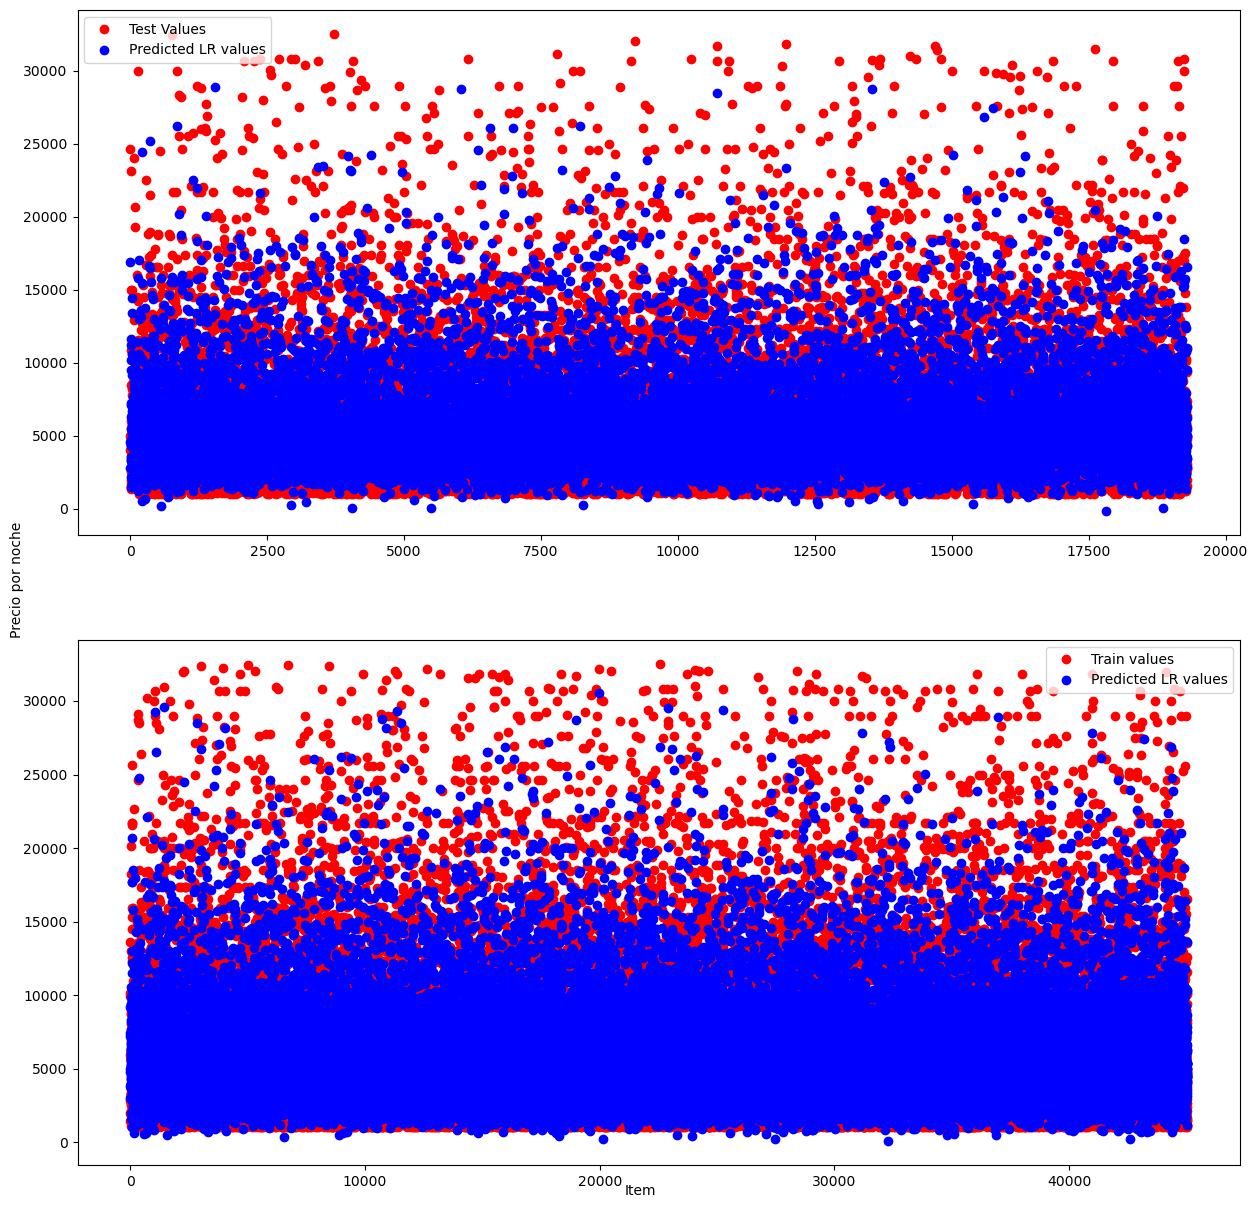

In [16]:
getscores(grid_cat.best_estimator_,X_test,y_test,X_train,y_train)

### XGBoost

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=2600, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)
{'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 2600, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
---- TEST ---
MAE   : 1854.343
MSE   : 8061130.992
RMSE  : 2839.213
R^2   : 0.6017497372007754
---- TRAIN ---
MAE   : 1

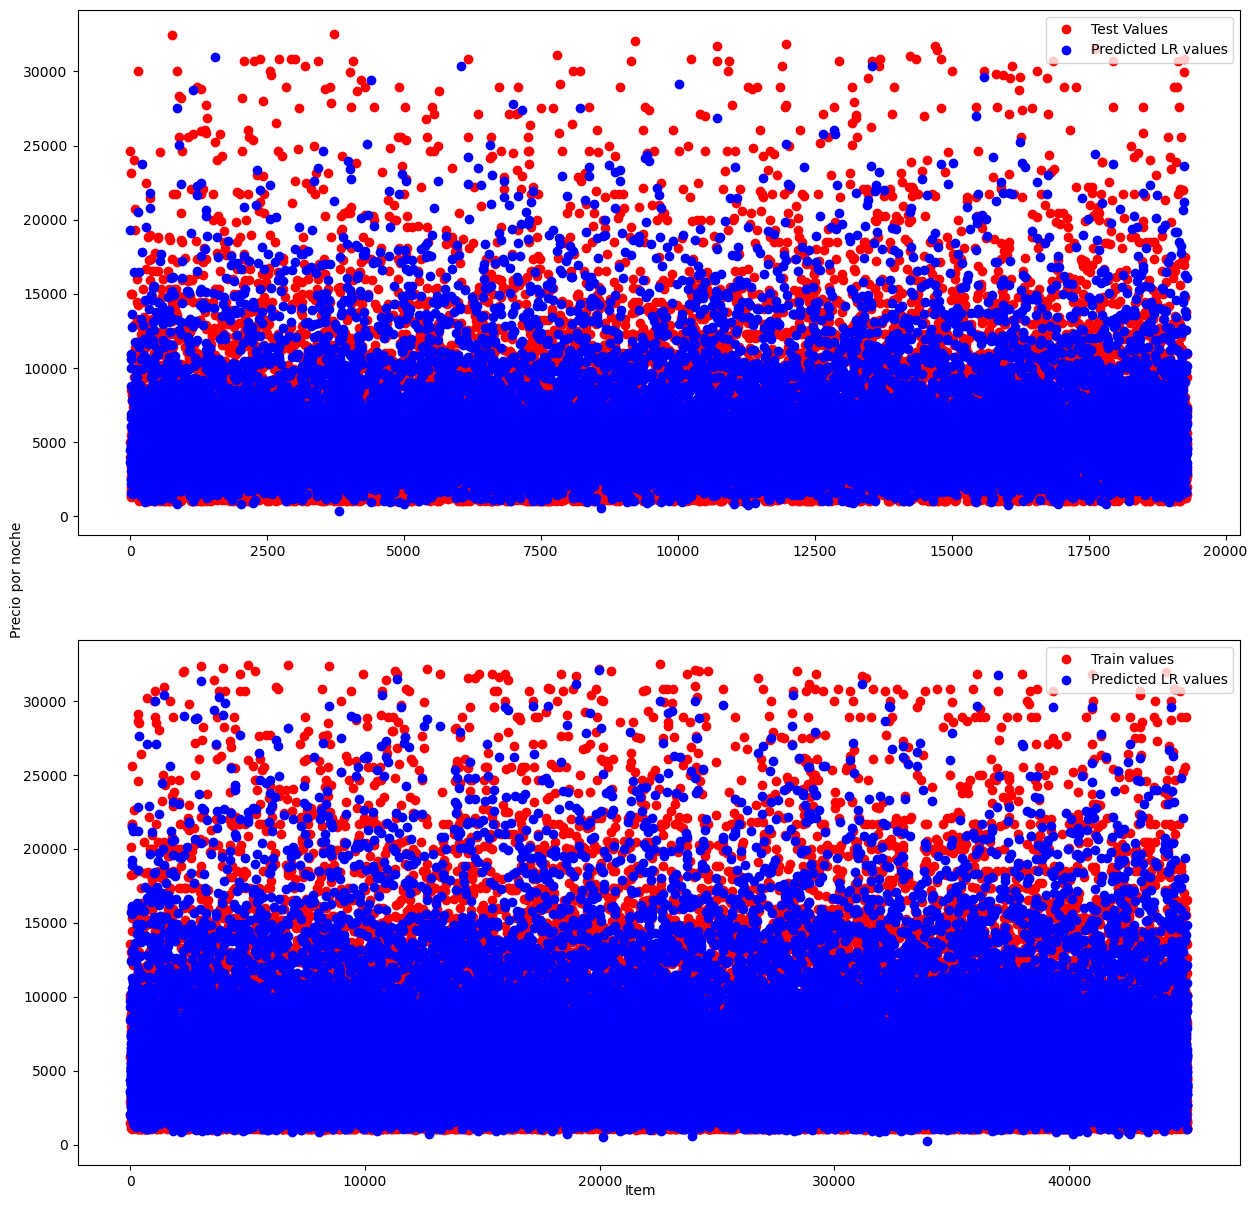

CPU times: user 48.1 s, sys: 4.77 s, total: 52.9 s
Wall time: 2min 57s


In [25]:
%%time

params_xgb = {  
    'n_estimators': [2600],
    'learning_rate': [0.01],    
    'max_depth': [10],
    'min_child_weight': [4],
   ## "tree_method":["gpu_hist"], ## run in gpu
    "colsample_bytree":[0.8],
    "subsample":[0.8],
    "eval_metric":["rmse"]
}

grid_xgb=GridSearchCV(xgb.XGBRegressor(), param_grid = params_xgb, cv=folds,verbose=1, n_jobs=-1)
  
grid_xgb.fit(X_train,y_train)

print(grid_xgb.best_estimator_)
print(grid_xgb.best_params_)
getscores(grid_xgb.best_estimator_,X_test,y_test,X_train,y_train)


In [26]:
joblib.dump(grid_xgb.best_estimator_,'model.sav')

['model.sav']

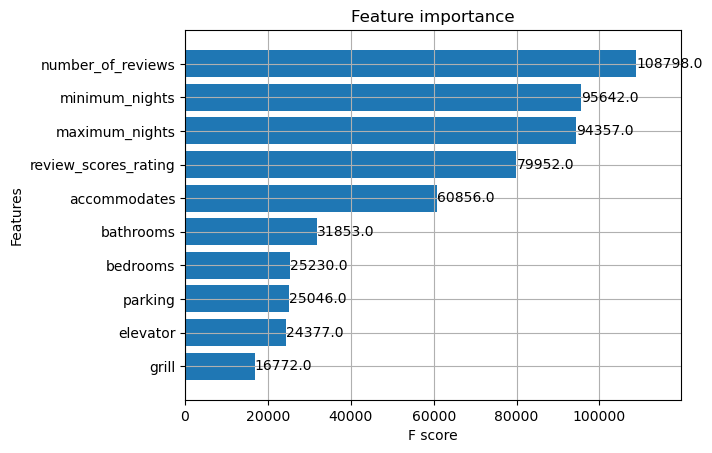

In [18]:
from xgboost import plot_importance
plot_importance(grid_xgb.best_estimator_, height = 0.8,max_num_features=10);

### LGBMRegressor

In [ ]:
%%time

params_lgb = {  
    'n_estimators': [8000],
    'learning_rate': [0.001],    
    'max_depth': [40],
    "num_leaves":[10],
    'min_child_weight': [4],
    "colsample_bytree":[0.8],
    "subsample":[0.8]
}

grid_lgb=GridSearchCV(lgb.LGBMRegressor(), param_grid = params_lgb, cv=folds,verbose=1, n_jobs=-1,scoring='neg_root_mean_squared_error')
  
grid_lgb.fit(X_train,y_train)
print(grid_lgb.best_estimator_)
print(grid_lgb.best_params_)
getscores(grid_lgb.best_estimator_,X_test,y_test,X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.7s finished


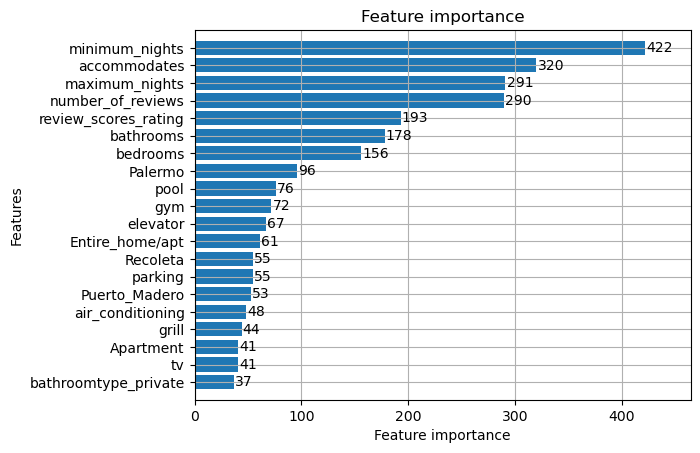

In [20]:
lgb.plot_importance(grid_lgb.best_estimator_, height = 0.8,max_num_features=20);

In [21]:
# joblib.dump(grid_cat.best_estimator_,'model.sav')